In [1]:
import pandas as pd # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap

df = pd.read_csv('../../data/cleaned/NFL_wk_by_wk_cleaned.csv')

temp = df.loc[:,['YEAR','WEEK_NUM','LOSER','WIN_OR_TIE']]
temp['WIN_OR_TIE'] = 0
temp.columns = ['YEAR','WEEK_NUM','WINNER','WIN_OR_TIE']

temp = pd.concat([df.loc[df['WIN_OR_TIE'].isin([0,1]),['YEAR','WEEK_NUM','WINNER','WIN_OR_TIE']], temp])
temp.columns = ['YEAR','WEEK_NUM','NFL_TEAM','WIN_OR_LOSS']

temp = temp.sort_values(['YEAR','NFL_TEAM','WEEK_NUM',])
temp = temp.loc[:,['YEAR','NFL_TEAM','WEEK_NUM','WIN_OR_LOSS']].reset_index().drop(['index'],axis=1)

temp['RECORD_WINS'] = temp.groupby(['YEAR','NFL_TEAM']).agg(WINS=('WIN_OR_LOSS', 'cumsum')).astype(int)
temp['RECORD_LOSSES'] = (temp.groupby(['YEAR','NFL_TEAM'])['WEEK_NUM'].rank() - temp['RECORD_WINS']).astype(int)
temp['WIN_OR_LOSS'] = temp['WIN_OR_LOSS'].astype(int)

for year in df['YEAR'].unique():
    for team in temp['NFL_TEAM'].unique():
        temp = pd.concat([temp, pd.DataFrame([[year, team, 0, 0, 0, 0]], columns=temp.columns)])

temp = temp.sort_values(['YEAR','NFL_TEAM','WEEK_NUM',])

weeks_per_season = {'1991-1992':17, 
                    '1992-1993':17, 
                    '1993-1994':18, 
                    '1994-1995':17, 
                    '1995-1996':17,
                    '1996-1997':17, 
                    '1997-1998':17, 
                    '1998-1999':17, 
                    '1999-2000':17, 
                    '2000-2001':17,
                    '2001-2002':17, 
                    '2002-2003':17, 
                    '2003-2004':17, 
                    '2004-2005':17, 
                    '2005-2006':17,
                    '2006-2007':17, 
                    '2007-2008':17, 
                    '2008-2009':17, 
                    '2009-2010':17, 
                    '2010-2011':17,
                    '2011-2012':17, 
                    '2012-2013':17, 
                    '2013-2014':17, 
                    '2014-2015':17, 
                    '2015-2016':17,
                    '2016-2017':17, 
                    '2017-2018':17, 
                    '2018-2019':17, 
                    '2019-2020':17, 
                    '2020-2021':17,
                    '2021-2022':18, 
                    '2022-2023':18, 
                    '2023-2024':18, 
                    '2024-2025':18}

######
# If you only want the '18-week' seaons
#  temp = temp.loc[temp['YEAR'].isin(['2021-2022','2022-2023','2023-2024','2024-2025'])]

# weeks_per_season = {'2021-2022':18, 
#                     '2022-2023':18, 
#                     '2023-2024':18, 
#                     '2024-2025':18}
######

playoff_teams_per_season = {}
for year in weeks_per_season.keys():
    playoff_teams_per_season[year] = pd.concat([df.loc[(df['YEAR']==year)&(df['WEEK_NUM']>weeks_per_season[year]),'WINNER'], 
                                                df.loc[(df['YEAR']==year)&(df['WEEK_NUM']>weeks_per_season[year]),'LOSER']]).unique()
    
for year in weeks_per_season.keys():
    temp.loc[(temp['YEAR']==year)&(temp['NFL_TEAM'].isin(playoff_teams_per_season[year])),'MADE_PLAYOFFS'] = 1

temp['MADE_PLAYOFFS'] = temp['MADE_PLAYOFFS'].fillna(0)
temp['MADE_PLAYOFFS'] = temp['MADE_PLAYOFFS'].astype(int)

for year in weeks_per_season.keys():
    temp.loc[(temp['YEAR']==year)&(temp['WEEK_NUM']<=weeks_per_season[year]),'TYPE'] = 'REG'
    temp.loc[(temp['YEAR']==year)&(temp['WEEK_NUM']>weeks_per_season[year]), 'TYPE'] = 'PLAYOFFS'    

if len(temp.loc[temp['YEAR']==sorted(temp['YEAR'].unique())[-1],'WEEK_NUM'].unique()) < 23:
    percentages = pd.pivot_table(temp.loc[(temp['TYPE']=='REG')&(temp['YEAR']!=sorted(temp['YEAR'].unique())[-1])], values='MADE_PLAYOFFS', index='RECORD_WINS', columns='RECORD_LOSSES', aggfunc='sum',fill_value=0)/pd.pivot_table(temp.loc[(temp['TYPE']=='REG')&(temp['YEAR']!=sorted(temp['YEAR'].unique())[-1])], values='MADE_PLAYOFFS', index='RECORD_WINS', columns='RECORD_LOSSES', aggfunc='count',fill_value=0)
else:
    percentages = pd.pivot_table(temp.loc[temp['TYPE']=='REG'], values='MADE_PLAYOFFS', index='RECORD_WINS', columns='RECORD_LOSSES', aggfunc='sum',fill_value=0)/pd.pivot_table(temp.loc[temp['TYPE']=='REG'], values='MADE_PLAYOFFS', index='RECORD_WINS', columns='RECORD_LOSSES', aggfunc='count',fill_value=0)
percentages = percentages.sort_values('RECORD_WINS',ascending=False)

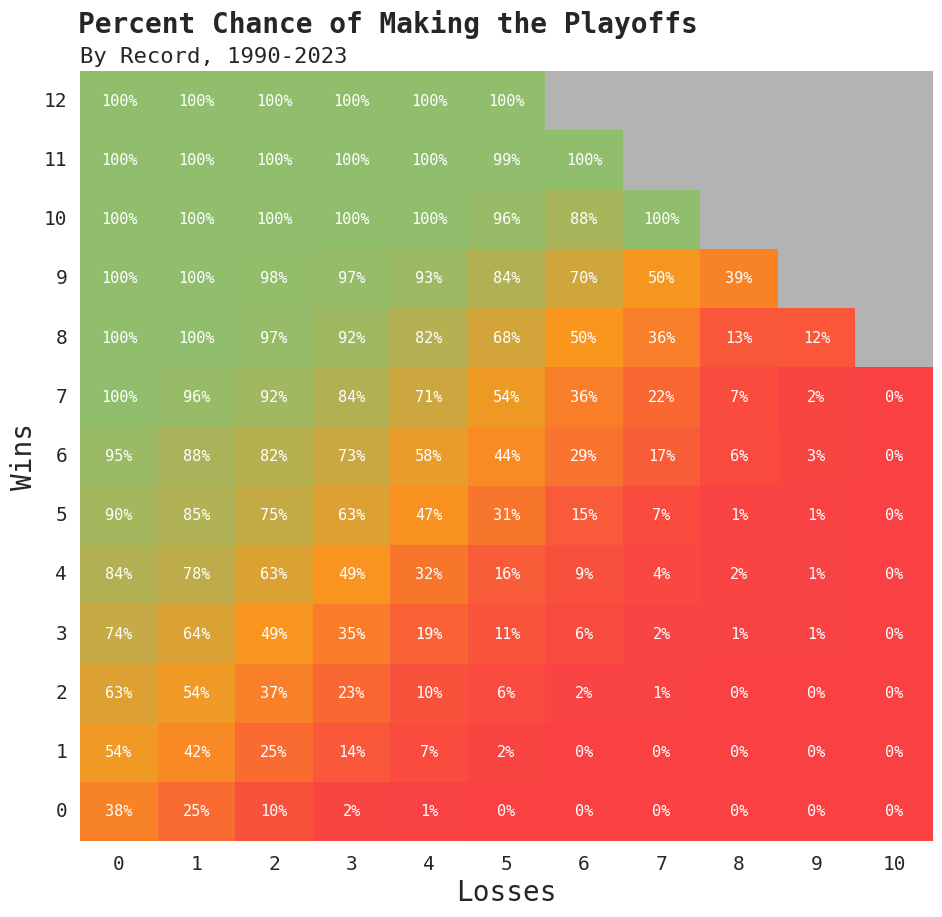

In [2]:
cmapGR = LinearSegmentedColormap.from_list('GreenOjRed', [(0.97647, 0.25490, 0.26667),
                                                          (0.97255, 0.58824, 0.11765),
                                                          (0.56471, 0.74510, 0.42745)])

sns.set_theme(style="white", font="DejaVu Sans Mono")

fig, ax = plt.subplots(figsize=(11, 10))
s = sns.heatmap(percentages.loc[[12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
                                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]],
                cmap=cmapGR,
                annot=True, 
                fmt = '.0%', 
                annot_kws={"size": 11, "color":'w',}, 
                cbar=False,
                ax=ax)
# Grey 'NaN' values
ax.collections[0].cmap.set_bad('0.7')

# Set Chart titles
ax.text(0.361, 1.05, "Percent Chance of Making the Playoffs",
        fontsize=20,
        fontweight='bold',
        transform=ax.transAxes, 
        ha="center",)
plt.title("By Record, 1990-2023",
          fontdict={'fontsize':16},
          loc='left')

# Set Axis Titles
plt.xlabel("Losses", fontsize=20)
plt.ylabel("Wins", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14, rotation=0) 

fig.savefig("../../data/images/percent_chance_of_making_playoffs_by_record.png", facecolor=ax.get_facecolor(), dpi=200)

plt.show()

In [6]:
pd.pivot_table(temp.loc[(temp['TYPE']=='REG')&(temp['YEAR']!=sorted(temp['YEAR'].unique())[-1])], values='MADE_PLAYOFFS', index='RECORD_WINS', columns='RECORD_LOSSES', aggfunc='sum',fill_value=0)

RECORD_LOSSES,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
RECORD_WINS,,,,,,,,,,,,,,,,
0,42,13,2,0,0,0,0,0,0,0,0,0,0,0,0,0
1,29,23,10,3,0,0,0,0,0,0,0,0,0,0,0,0
2,17,24,15,11,5,3,1,0,0,0,0,0,0,0,0,0
3,8,20,14,11,8,6,4,1,0,0,0,0,0,0,0,0
4,4,13,12,9,5,3,4,2,1,0,0,0,0,0,0,0
5,4,12,11,13,10,6,4,2,1,0,0,0,0,0,0,0
6,2,9,11,12,9,7,8,6,3,0,0,0,0,0,0,0
7,2,5,9,14,12,7,10,7,4,0,0,0,0,0,0,0
8,1,4,6,12,10,3,8,10,6,1,0,0,0,0,0,0


In [22]:
checker = temp.loc[(temp['TYPE']=='REG')&
         (temp['YEAR']!=sorted(temp['YEAR'].unique())[-1])&
         (temp['MADE_PLAYOFFS']==1),['YEAR','NFL_TEAM','RECORD_WINS','RECORD_LOSSES']].groupby(['YEAR','RECORD_WINS','RECORD_LOSSES'])['NFL_TEAM'].apply(list).to_frame()



In [41]:
current_year = '2021-2022'
for row in checker.iterrows():
    if row[0][0] != current_year:
        print()
        current_year = row[0][0]
    print(f"{row[0][0]} Teams that had a record of {row[0][1]}-{row[0][2]}: {row[1].NFL_TEAM}")
    

2021-2022 Teams that had a record of 0-0: ['Arizona Cardinals', 'Buffalo Bills', 'Cincinnati Bengals', 'Dallas Cowboys', 'Green Bay Packers', 'Kansas City Chiefs', 'Las Vegas Raiders', 'Los Angeles Rams', 'New England Patriots', 'Philadelphia Eagles', 'Pittsburgh Steelers', 'San Francisco 49ers', 'Tampa Bay Buccaneers', 'Tennessee Titans']
2021-2022 Teams that had a record of 0-1: ['Buffalo Bills', 'Dallas Cowboys', 'Green Bay Packers', 'New England Patriots', 'Tennessee Titans']
2021-2022 Teams that had a record of 1-0: ['Arizona Cardinals', 'Cincinnati Bengals', 'Kansas City Chiefs', 'Las Vegas Raiders', 'Los Angeles Rams', 'Philadelphia Eagles', 'Pittsburgh Steelers', 'San Francisco 49ers', 'Tampa Bay Buccaneers']
2021-2022 Teams that had a record of 1-1: ['Buffalo Bills', 'Cincinnati Bengals', 'Dallas Cowboys', 'Green Bay Packers', 'Kansas City Chiefs', 'New England Patriots', 'Philadelphia Eagles', 'Pittsburgh Steelers', 'Tennessee Titans']
2021-2022 Teams that had a record of 1-2

In [4]:
percentages

RECORD_LOSSES,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
RECORD_WINS,,,,,,,,,,,,,,,,
14,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,1.000000,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,0.857143,0.666667,0.388889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.000000,1.000000,1.000000,0.857143,0.833333,0.500000,0.571429,0.588235,0.333333,0.125,NaN,NaN,NaN,NaN,NaN,NaN
7,1.000000,1.000000,1.000000,0.823529,0.857143,0.583333,0.476190,0.333333,0.190476,0.000,0.0,NaN,NaN,NaN,NaN,NaN
6,1.000000,1.000000,0.846154,0.705882,0.642857,0.411765,0.444444,0.400000,0.272727,0.000,0.0,0.0,NaN,NaN,NaN,NaN
